# Webscraping and analyzing Swarvoski jewellery

## Web scraping

In [1]:
#Loading libraries
%matplotlib inline
import json
import requests
import numpy as np
import pandas as pd
import seaborn as sns
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import datetime as dt

In [2]:
#Urls of the different webpages
urls = ["https://www.swarovski.com/en_GB-CA/c-0103/Categories/Jewellery/Earrings/f/?sort=newIn&page=7&loadMore=true&show=All",
        "https://www.swarovski.com/en_GB-CA/c-0101/Categories/Jewellery/Necklaces-and-pendants/f/?sort=newIn&page=9&loadMore=true&show=All",
        "https://www.swarovski.com/en_GB-CA/c-0104/Categories/Jewellery/Bracelets/f/?sort=newIn&page=7&loadMore=true&show=All",
        "https://www.swarovski.com/en_GB-CA/c-0106/Categories/Jewellery/Rings/f/?sort=newIn&page=5&loadMore=true&show=All", 
        "https://www.swarovski.com/en_GB-CA/c-0107/Categories/Jewellery/Brooches/"]

#Dictionary of the products with the
#name, price, category, number of colors
#available, discount, flag and collection
product_dict = {"name": [], "price": [], "category": [], "colours_available": [], 
                "discount": [], "flag": [], "collection": []}

#Webscraping the html page
for url in urls:
    response = requests.get(url)
    soup = BeautifulSoup(response.content, "html.parser")

    #Category of each page
    category_json = soup.find("script", type = "application/ld+json").string
    category_dict = json.loads(category_json)
    category = category_dict["itemListElement"][1]["item"]["name"]

    products_html = soup.find_all("div", class_ = "swa-product-tile-wrapper js-swa-product-tile-wrapper")
    for product in products_html:
        try:
            #Getting the name of the earring
            if bool(product.find("p", class_="swa-product-tile__information__name js-swa-product-tile-name").text):
                product_name = product.find("p", class_="swa-product-tile__information__name js-swa-product-tile-name").text
                product_dict["name"].append(product_name)
            else:
                product_dict["name"].append(np.nan)
                
            #Getting the price of the earrings
            #Some earrings are on sale so the 
            #original price is the of a different class
            if bool(product.find("span", class_ = "swa-product-tile__information__price-old")):
                price = product.find("span", class_ = "swa-product-tile__information__price-old").text
                product_dict["price"].append(price)
            else:
                price = product.find("span", class_ = "swa-product-tile__information__price-current").text
                product_dict["price"].append(price)        
            
            #Getting the colours_available flag
            #Some earrings are not available
            #in different colours, so they do 
            #not have a flag for the colours
            if bool(product.find("span", class_ = "swa-flags__labeled__flag")):
                flag_1 = product.find("span", class_ = "swa-flags__labeled__flag").text
                if "colours" in flag_1.lower():
                    product_dict["colours_available"].append(flag_1)
                    product_dict["discount"].append(np.nan)
                if "%" in flag_1:
                    product_dict["discount"].append(flag_1)
                    product_dict["colours_available"].append(np.nan)
            else:
                product_dict["colours_available"].append(np.nan)
                product_dict["discount"].append(np.nan)

            #The flag for products include
            #"New", "Sale" or "Out of stock" or 
            #The collection
            if bool(product.find("span", class_ = "swa-flags__unlabeled__flag")):
                flag = product.find("span", class_ = "swa-flags__unlabeled__flag").text
                flag_lower = flag.lower()
                if "stock" in flag_lower or "sale" in flag_lower or "new" in flag_lower:
                    product_dict["flag"].append(flag)
                    product_dict["collection"].append(np.nan)
                else:
                    product_dict["flag"].append(np.nan)
                    product_dict["collection"].append(flag)

            else:
                product_dict["flag"].append(np.nan)
                product_dict["collection"].append(np.nan)

            category = category_dict["itemListElement"][1]["item"]["name"]
            product_dict["category"].append(category)

        except:
            continue

In [3]:
#Creating the dataframe and showing the 
#first five rows
df = pd.DataFrame.from_dict(product_dict)
df["date_scraped"] = dt.date.today()
df.head()

,name,price,category,colours_available,discount,flag,collection,date_scraped
0,"Polar Bestiary Hoop Pierced Earrings, Multi-co...",199.00 $,Earrings,NaN,\n −50%,\n Sale,NaN,2021-01-27
1,"Swarovski Symbolic Lotus Pierced Earrings, Gre...",149.00 $,Earrings,NaN,\n −50%,\n Sale,NaN,2021-01-27
2,"Shell Coral Pierced Earrings, Red, Gold-tone p...",139.00 $,Earrings,NaN,\n −50%,\n Sale,NaN,2021-01-27
3,Swarovski Sparkling Dance Rainbow Pierced Earr...,139.00 $,Earrings,NaN,\n −50%,\n Sale,NaN,2021-01-27
4,"Nice Stud Pierced Earrings, White, Rhodium plated",89.00 $,Earrings,NaN,\n −50%,\n Sale,NaN,2021-01-27


## Data cleaning

In [4]:
def get_plating(word):
    """ This function extracts 
    the plating from the name """
    
    if "plated" in word.lower():
        return word
    else:
        return np.nan

In [5]:
def get_colour(word):
    """ This function extracts 
    the colour from the name"""
    
    colours = ["white", "blue", "green", "pink", "black", "red", 
              "grey", "aqua", "multi", "light", "dark", "gold", 
              "yellow", "brown", "purple", "beige", "silver", 
              "orange", "teal"]
    
    if any(colour in str(word).lower() for colour in colours):
        return word
    else:
        return np.nan

In [6]:
def get_finish(word):
    """ This function extracts 
    the finish from the name"""
    
    if "finish" in word.lower():
        return word
    else:
        return np.nan

In [7]:
def get_stainless_steel(word):
    
    """ This function find whether or not 
    the product is stainless steel from the name"""
    
    if "steel" in word.lower():
        return word
    else:
        return np.nan

In [8]:
#Cleaning the flag column
df["flag"] = df.flag.str.strip().str.capitalize()

In [9]:
#Getting the plating of the jewellery
df["plating"] = df.name.str.split(",", n = 3).str[-1].apply(get_plating)
df["plating"] = df.plating.str.strip()

In [10]:
#Creating a column for stainless steel products
df["stainless_steel"] = df.name.str.split(",", n = 3).str[-1].apply(get_stainless_steel)

In [11]:
#Creating a column for the colour
df["colour"] = df.name.str.split(",", n = 3).str[-2].apply(get_colour)
df["colour"] = df.colour.str.strip().str.capitalize()

In [12]:
#Creating a column for the finish
df["finish"] = df.name.str.split(",", n = 3).str[-1].apply(get_finish)

In [13]:
#Cleaning the colors_available columns
df["colours_available"] = df.colours_available.str.strip().str.lower()

In [14]:
#Cleaning the price column
df["price"] = df.price.str.strip("$").str.strip()
df["price"] = df.price.astype("float")

In [15]:
#Changing the category column to category datatype
df["category"] = df.category.astype("category")

In [16]:
#Cleaning the discount column
df["discount"] = df.discount.str.strip().str[1:]

In [17]:
#Cleaning the collection column
df["collection"] = df.collection.str.strip().str.title()

In [18]:
#Removing the colour, plating, or finish from the name
df["name"] = df.name.str.split(",", n = 3).str[0]

In [19]:
#Checking the datatypes
df.dtypes

name                   object
price                 float64
category             category
colours_available      object
discount               object
flag                   object
collection             object
date_scraped           object
plating                object
stainless_steel        object
colour                 object
finish                 object
dtype: object

In [20]:
#Checking the columns for null values
#Only the name, price and category columns
#can be null
df.isnull().sum()

name                   0
price                  0
category               0
colours_available    728
discount             547
flag                 491
collection           844
date_scraped           0
plating              149
stainless_steel      939
colour                23
finish               866
dtype: int64

In [21]:
#Checking the cleaned dataframe
df.head()

,name,price,category,colours_available,discount,flag,collection,date_scraped,plating,stainless_steel,colour,finish
0,Polar Bestiary Hoop Pierced Earrings,199.0,Earrings,NaN,50%,Sale,NaN,2021-01-27,Rhodium plated,NaN,Multi-coloured,NaN
1,Swarovski Symbolic Lotus Pierced Earrings,149.0,Earrings,NaN,50%,Sale,NaN,2021-01-27,Gold-tone plated,NaN,Green,NaN
2,Shell Coral Pierced Earrings,139.0,Earrings,NaN,50%,Sale,NaN,2021-01-27,Gold-tone plated,NaN,Red,NaN
3,Swarovski Sparkling Dance Rainbow Pierced Earr...,139.0,Earrings,NaN,50%,Sale,NaN,2021-01-27,Gold-tone plated,NaN,Light multi-coloured,NaN
4,Nice Stud Pierced Earrings,89.0,Earrings,NaN,50%,Sale,NaN,2021-01-27,Rhodium plated,NaN,White,NaN


### Creating the subsets

In [22]:
#Dataframe for earrings
earrings_df = df.loc[df.category == "Earrings"].copy()

#Dataframe for products on sales
#at the time of creating this notebook
sales_df = df.loc[df.flag == "Sale"].copy()
sales_df.reset_index(drop = True, inplace = True)

#Dataframe of the "Atelier Swarovski"
#collection
as_df = df.loc[df.collection == "Atelier Swarovski"].copy()
as_df.reset_index(drop = True, inplace = True)

In [23]:
def get_earring_type(word):
    "This function returns the type of earring"
    word = word.lower()
    if "stud" in word:
        return "Stud"
    elif "hoop" in word:
        return "Hoop"
    elif "drop" in word:
        return "Drop"
    elif "pierced" in word:
        return "Pierced"
    elif "clip" in word:
        return "Clip"
    elif "cuff" in word:
        return "Cuff"
    
    else:
        return "Other"

In [24]:
#Creating a column with the type of earring
earrings_df["type"] = earrings_df.name.apply(get_earring_type)

## Exploratory data analysis

##### ***How many products are available in each category?***

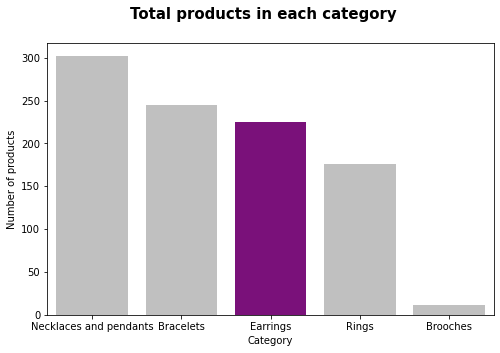

In [25]:
#Dataframe of the category value counts
category_count = pd.DataFrame(df.category.value_counts()).reset_index()
category_count.rename(columns = 
                      {"index":"category", "category": "num_products"}, inplace = True)

#Creating the bar graph
color_palette = ["#C0C0C0", "#C0C0C0", "#8B008B", "#C0C0C0",  "#C0C0C0"]
labels_order = ["Necklaces and pendants", "Bracelets", "Earrings", "Rings", "Brooches"]
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x = "category", y = "num_products", data = category_count, 
            order = labels_order, palette = color_palette, ax = ax)

ax.set_xlabel("Category")
ax.set_ylabel("Number of products")
fig.suptitle("Total products in each category", fontsize = 15, fontweight = "bold")
plt.show()

#### ***What is the distribution of prices in each category?***

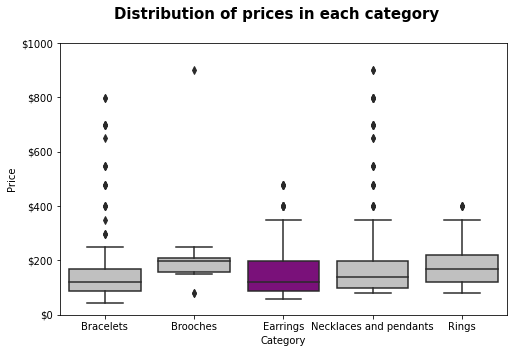

In [26]:
color_palette = ["#C0C0C0", "#C0C0C0", "#8B008B", "#C0C0C0",  "#C0C0C0"]

#Creating the boxplot
fig, ax = plt.subplots(figsize = (8,5))
sns.boxplot(x = "category", y = "price", palette = color_palette, data = df, ax = ax)
ax.set_xlabel("Category")
ax.set_ylabel("Price")
ax.set_ylim((0,1000))

formatter = ticker.FormatStrFormatter("$%1.0f")
ax.yaxis.set_major_formatter(formatter)

fig.suptitle("Distribution of prices in each category", fontsize = 15, fontweight = "bold")
plt.show()

#### ***What are the prices of products in each category?***

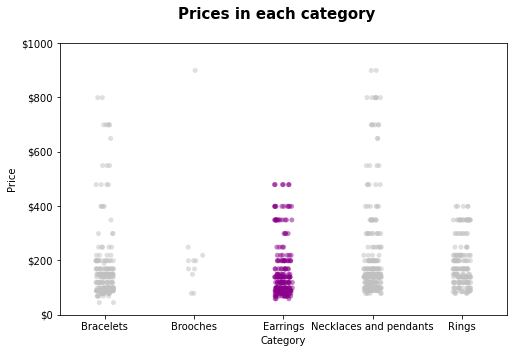

In [27]:
color_palette = ["#C0C0C0", "#C0C0C0", "#8B008B", "#C0C0C0",  "#C0C0C0"]

#Creating the stripplot
fig, ax = plt.subplots(figsize = (8,5))
sns.stripplot(x = "category", y = "price", data = df, palette = color_palette, jitter = True, ax = ax, alpha = 0.5)
ax.set_xlabel("Category")
ax.set_ylabel("Price")
ax.set_ylim((0,1000))

formatter = ticker.FormatStrFormatter("$%1.0f")
ax.yaxis.set_major_formatter(formatter)

fig.suptitle("Prices in each category", fontsize = 15, fontweight = "bold")
plt.show()

#### ***What is the average price of products in each collection?***

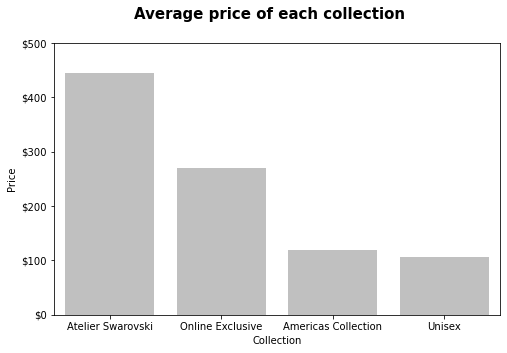

In [28]:
#Creating the dataframe of the average price
#and count of products in each collection
collections = df.groupby("collection", as_index = False).agg({"price": "mean", "name": "count"})
collections.rename(columns = {"name": "num_products"}, inplace = True)
collections = collections.loc[collections.num_products > 1]
collections = collections.sort_values("price", ascending = False)

fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x = "collection", y= "price", data = collections, color = "#C0C0C0", ax = ax)

formatter = ticker.FormatStrFormatter("$%1.0f")
ax.yaxis.set_major_formatter(formatter)
ax.set_ylabel("Price")
ax.set_xlabel("Collection")
ax.set_ylim((0,500))

fig.suptitle("Average price of each collection", fontsize = 15, fontweight = "bold")

plt.show()

#### ***What are the different prices for each type of plating?***

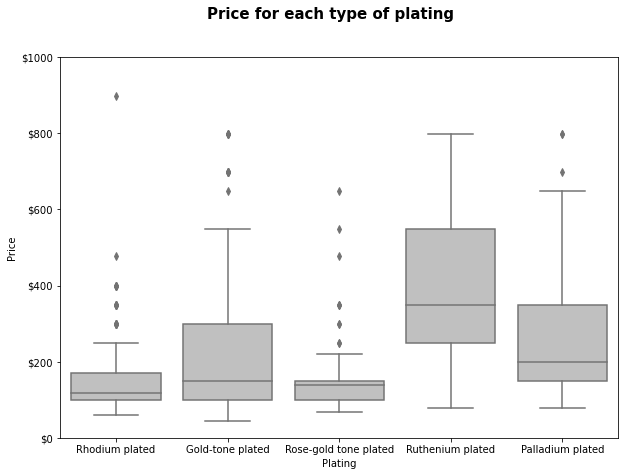

In [29]:
#Creating the subset of the products
#with plating information
plated = df.loc[~df.plating.isnull()].copy()
fig, ax = plt.subplots(figsize = (10,7))

#Creating the boxplot
sns.boxplot(x = "plating", y = "price", data = plated, color = "#C0C0C0", ax = ax)
ax.set_ylabel("Price")
ax.set_xlabel("Plating")
ax.set_ylim((0,1000))

formatter = ticker.FormatStrFormatter("$%1.0f")
ax.yaxis.set_major_formatter(formatter)

fig.suptitle("Price for each type of plating", fontsize = 15, fontweight = "bold")
plt.show()

#### ***Average price of each category in the Atelier Swarovski collection***

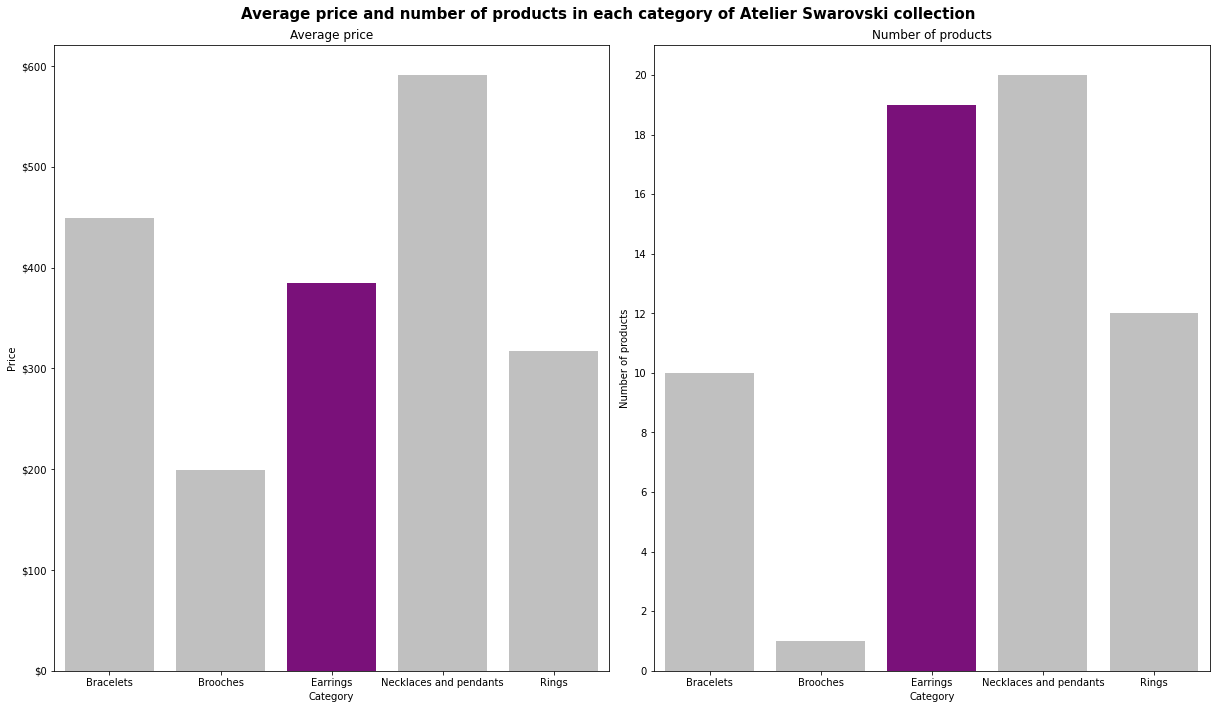

In [30]:
#Creating the dataframe of the 
#Atelier Swarovski collection
as_group = as_df.groupby("category", as_index = False).agg({"name": "count", "price": "mean"})
as_group.rename(columns = {"name": "num_product"}, inplace = True)
as_group = as_group.reset_index(drop = True)

#Creating 2 barplots of the 
#average price and number of products
#in the collection
fig, (ax1, ax2) = plt.subplots(1,2, figsize = (17,10))
sns.barplot(x = "category", y = "price", data = as_group, palette = color_palette, ax = ax1)
sns.barplot(x = "category", y = "num_product", data = as_group, palette = color_palette,  ax = ax2)

ax1.set_title("Average price")
ax1.set_ylabel("Price")
ax1.set_xlabel("Category")

ax2.set_title("Number of products")
ax2.set_ylabel("Number of products")
ax2.set_xlabel("Category")

yticks = [i for i in range(0,22,2)]
ax2.set_yticks(yticks)

formatter = ticker.FormatStrFormatter("$%1.0f")
ax1.yaxis.set_major_formatter(formatter)

fig.suptitle("Average price and number of products in each category of Atelier Swarovski collection", 
             fontsize = 15, fontweight = "bold")
plt.tight_layout()
plt.show()

#### ***How many products are available in more than one colour?***

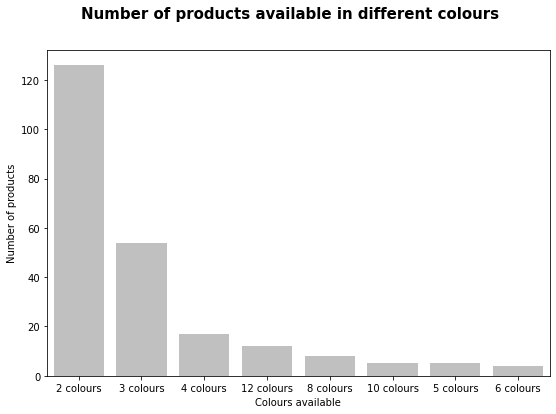

In [31]:
#Creating the dataframe of the 
#colours available
colours_available = pd.DataFrame(df.colours_available.value_counts()).reset_index()
colours_available = colours_available.sort_values("colours_available", ascending = False)
colours_available.rename(columns = {"index":"colors_available", "colours_available": "num_products"}, inplace = True)

fig, ax = plt.subplots(figsize = (9,6))
sns.barplot(x = "colors_available", y = "num_products", data = colours_available, color = "#C0C0C0", ax = ax)
ax.set_ylabel("Number of products")
ax.set_xlabel("Colours available")

fig.suptitle("Number of products available in different colours", fontsize = 15, fontweight = "bold")
plt.show()

#### ***What percent of the sale was each category?***

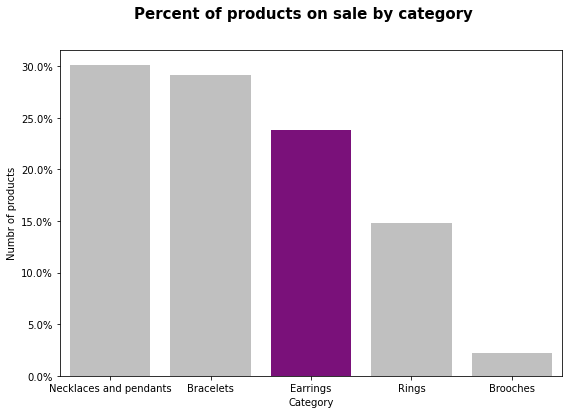

In [32]:
#Dataframe of the products that were 
#on sale
sales_by_category = sales_df.groupby("category", as_index = False)[["name"]].count()
sales_by_category = sales_by_category.sort_values("name", ascending = False)
sales_by_category = sales_by_category.reset_index(drop = True)
sales_by_category = sales_by_category.rename(columns = {"name": "total"}).copy()
sales_by_category["percent"] = sales_by_category.total / sales_by_category.total.sum()

#Creating the bar graph of the 
#products on sale
fig, ax = plt.subplots(figsize = (9,6))
xlabel_order = ["Necklaces and pendants", "Bracelets", "Earrings", "Rings", "Brooches"]
sns.barplot(x = "category", y = "percent", data = sales_by_category,
            order = xlabel_order,  palette = color_palette, ax = ax)

ax.set_xlabel("Category")
ax.set_ylabel("Numbr of products")


formatter = ticker.PercentFormatter(xmax = 1.0)
ax.yaxis.set_major_formatter(formatter)
fig.suptitle("Percent of products on sale by category", fontsize = 15, fontweight = "bold")
plt.show()


### ***Discount amounts***

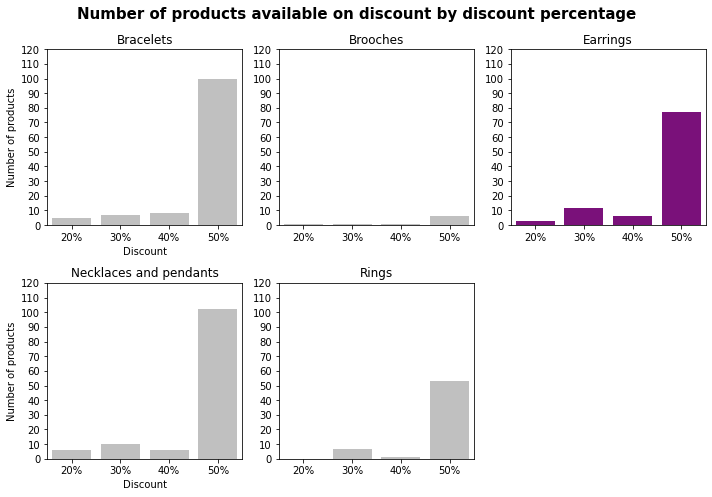

In [33]:
discount_by_category = sales_df.groupby(["discount", "category"], as_index = False)["name"].count()
discount_by_category = discount_by_category.reset_index(drop = True)

categories_list = discount_by_category.category.unique().to_list()
fig = plt.figure(figsize = (10,7))

#Creating subplots of the different
#discount amounts for each category
for index in range(0,5):
    ax = fig.add_subplot(2,3, 1 + index)
    temp_df = discount_by_category.loc[discount_by_category.category == categories_list[index]]
    if index == 2:
        sns.barplot(x = "discount", y = "name", data = temp_df, color = "#8B008B", ax = ax)
    else:
        sns.barplot(x = "discount", y = "name", data = temp_df, color = "#C0C0C0", ax = ax)
    
    if index == 0 or index == 3:
        ax.set_ylabel("Number of products")
        ax.set_xlabel("Discount")
    else:
        ax.set_ylabel("")
        ax.set_xlabel("")

    ax.set_title(categories_list[index])
    ax.set_ylim((0,120))
    yticks = [i for i in range(0,130, 10)]
    ax.set_yticks(yticks)

fig.suptitle("Number of products available on discount by discount percentage",
             fontsize = 15, fontweight = "bold")
plt.tight_layout()
plt.show()

### Earrings

#### ***What is the distribution of prices for earrings?***

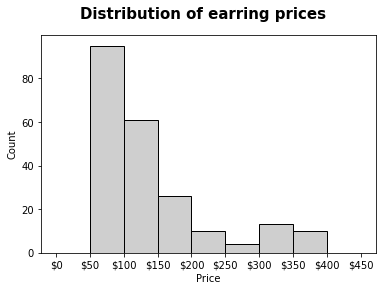

In [34]:
#Creating the histogram of earring prices 
price_bins = [i for i in range(0, int(round(earrings_df.price.max(), -1) + 20), 50)]
fig, ax = plt.subplots()
sns.histplot(x = "price", data = earrings_df, stat = "count", bins = price_bins, ax = ax, color = "#C0C0C0")
ax.set_xlabel("Price")
ax.set_xticks(price_bins)

formatter = ticker.FormatStrFormatter("$%1.0f")
ax.xaxis.set_major_formatter(formatter)

fig.suptitle("Distribution of earring prices", fontsize = 15, fontweight = "bold")
plt.show()

#### ***What is the minimum price of earrings?***

In [35]:
min_price = earrings_df.price.min()
print(f"${min_price}")

$59.0


#### ***What is the maximum price of earrings?***

In [36]:
max_price = earrings_df.price.max()
print(f"${max_price}")

$479.0


#### ***How many different types of earrings are available?***

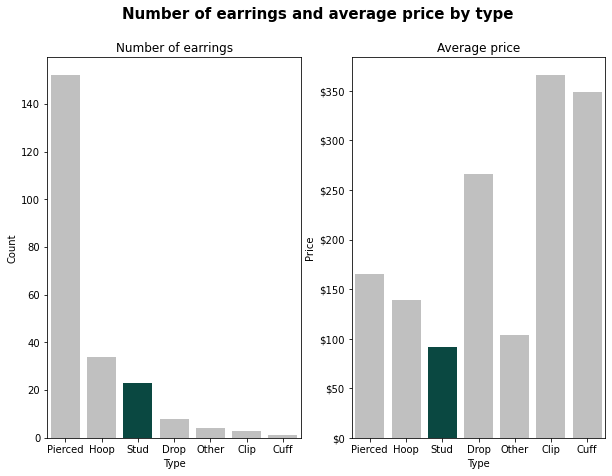

In [37]:
earrings_by_type = earrings_df.groupby("type", as_index = False).agg({"name": "count", "price": "mean"})
earrings_by_type.rename(columns = {"name": "count"}, inplace = True)
earrings_by_type = earrings_by_type.sort_values("count", ascending = False)

#Creating 2 barplots of the 
#average price and number of products
#of each type of earring
earring_palette = ["#C0C0C0", "#C0C0C0", "#005249", "#C0C0C0", "#C0C0C0", "#C0C0C0", "#C0C0C0"]
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10,7))
sns.barplot(x = "type", y = "count", data = earrings_by_type, ax = ax1, palette = earring_palette)
sns.barplot(x = "type", y = "price", data = earrings_by_type, ax = ax2, palette = earring_palette)

ax1.set_xlabel("Type")
ax1.set_ylabel("Count")
ax1.set_title("Number of earrings")

ax2.set_xlabel("Type")
ax2.set_ylabel("Price")
ax2.set_title("Average price")

formatter = ticker.FormatStrFormatter("$%1.0f")
ax2.yaxis.set_major_formatter(formatter)

fig.suptitle("Number of earrings and average price by type", fontsize = 15, fontweight = "bold")
plt.show()

#### ***What is the distribution of prices of earrings by type?***

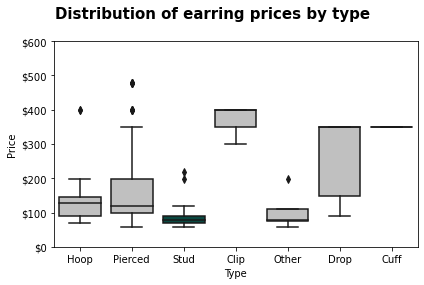

In [38]:
#Creating histograms of the prices of earrings
fig, ax = plt.subplots()
sns.boxplot(x = "type", y = "price", data = earrings_df, palette = earring_palette, ax = ax)

ax.set_ylabel("Price")
ax.set_xlabel("Type")
ax.set_ylim((0,600))

formatter = ticker.FormatStrFormatter("$%1.0f")
ax.yaxis.set_major_formatter(formatter)

fig.suptitle("Distribution of earring prices by type", fontsize = 15, fontweight = "bold")
plt.tight_layout()
plt.show()

#### ***What are the top 5 cheapest and expensive earrings?***

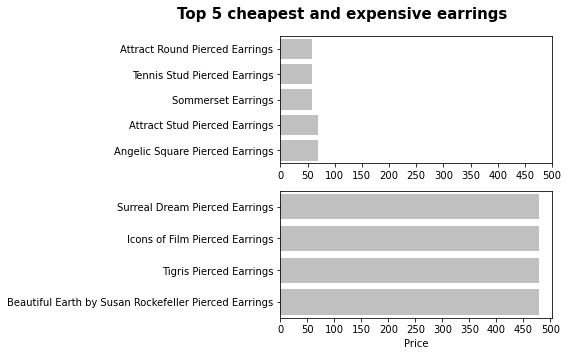

In [39]:
#Sorting the earrings by price in ascending other
sorted_earrings = earrings_df.sort_values("price")
dataframes = [sorted_earrings.head(), sorted_earrings.tail()]

#Creating suplots of the cheapest 
#and most expensive earrings
fig = plt.figure(figsize = (8,5))
for index in range(0,2):
    ax = fig.add_subplot(2,1,index +1)
    sns.barplot(x = "price", y = "name", data = dataframes[index], color = "#C0C0C0", orient = "h", ax = ax)
    xticks = [i for i in range(0,550,50)]
    ax.set_xticks(xticks)
    ax.set_xlim = (0,500)
    if index == 1:
        ax.set_xlabel("Price")
    else:
        ax.set_xlabel("")
    ax.set_ylabel("")


fig.suptitle("Top 5 cheapest and expensive earrings", x = 0.6, fontsize = 15, fontweight = "bold")
plt.tight_layout()
plt.show()

#### ***How many earrings are available in different colours?***

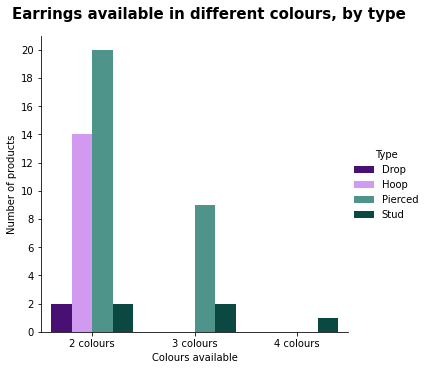

In [40]:
#Grouping the earrings by the colours available 
earrings_colours = earrings_df.loc[~earrings_df.colours_available.isnull()].copy()
earrings_colours_group = earrings_colours.groupby(["type" , "colours_available"], 
                                                  as_index = False)["name"].count()
earrings_colours_group.rename(columns = {"name": "count"}, inplace = True)

#Creating a grouped bar chart of the 
#colours available
color_palette = ["#4B0082", "#D68AFF", "#449F93", "#005249"]
g = sns.catplot(x = "colours_available", y = "count", hue = "type", 
                data = earrings_colours_group, kind = "bar", palette = color_palette)
plt.suptitle("Earrings available in different colours, by type", 
             fontsize = 15, fontweight = "bold" )

yticks = [i for i in range(0,22,2)]
g.set(yticks = yticks)

g.axes[0,0].set_ylabel("Number of products")
g.axes[0,0].set_xlabel("Colours available")
g._legend.set_title("Type")

plt.subplots_adjust(top = 0.9)
plt.show()

#### ***What are the prices of Atelier Swarovski Collection earrings?*** 

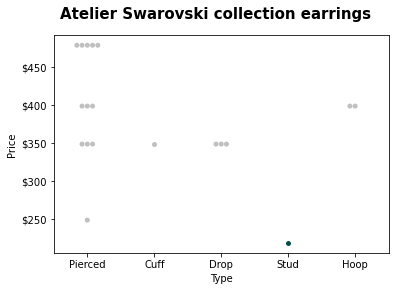

In [41]:
as_earrings = earrings_df.loc[earrings_df.collection == "Atelier Swarovski"].copy()
as_earrings.groupby("plating", as_index = False)[["price"]].mean()

earring_palette = ["#C0C0C0", "#C0C0C0", "#C0C0C0", "#005249", "#C0C0C0"]

#Creating the swarmplot of the 
#Atelier Collection earrings
fig, ax = plt.subplots()
sns.swarmplot(x = "type", y = "price", data = as_earrings, palette = earring_palette, ax = ax)
ax.set_ylabel("Price")
ax.set_xlabel("Type")

formatter = ticker.FormatStrFormatter("$%1.0f")
ax.yaxis.set_major_formatter(formatter)

fig.suptitle("Atelier Swarovski collection earrings", 
             fontsize = 15, fontweight = "bold" )
plt.show()

#### ***What is the cheapest Atelier Swarovski Collection earring?***

In [42]:
columns = ["name", "price", "colours_available", "colour", "finish"]
pd.set_option("display.max_colwidth", None)
print(as_earrings[columns].nsmallest(1, columns = "price").transpose())

                                                                          214
name               Beautiful Earth by Susan Rockefeller Stud Pierced Earrings
price                                                                     219
colours_available                                                         NaN
colour                                                                  Green
finish                                                                    NaN


#### ***What is the most expensive Atelier Swarovski Collection earring?***

In [43]:
pd.set_option("display.max_colwidth", None)
print(as_earrings[columns].nlargest(1, columns = "price").transpose())

                                        98
name               Tigris Pierced Earrings
price                                  479
colours_available                2 colours
colour                               White
finish                                 NaN


#### ***How many different colours are available for the pierced earrings?***

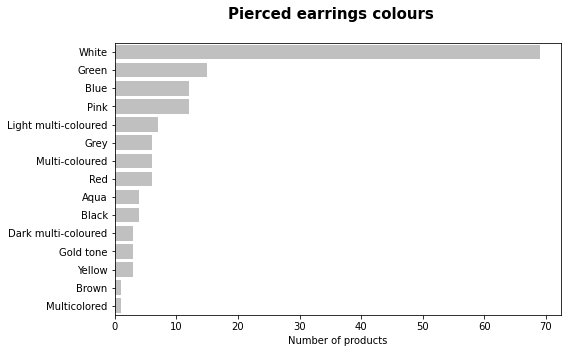

In [44]:
#Grouping the earrings by colour 
earrings_by_colour = earrings_df.loc[earrings_df.type == "Pierced"].groupby(["colour"], as_index = False)["name"].count()
earrings_by_colour.rename(columns = {"name": "count"}, inplace = True)
earrings_by_colour = earrings_by_colour.sort_values("count", ascending = False)

#Creating the bar graph of 
#the different colour  
fig, ax = plt.subplots(figsize = (8,5))
sns.barplot(x = "count", y = "colour", data = earrings_by_colour, color = "#C0C0C0", orient = "h", ax = ax)
ax.set_ylabel("")
ax.set_xlabel("Number of products")

fig.suptitle("Pierced earrings colours", fontsize = 15, fontweight = "bold")
plt.show()

In [45]:
#Saving the dataframes to excel
with pd.ExcelWriter("swarovski_jewellery.xlsx") as writer:
    df.to_excel(writer, sheet_name = "Swarovski_data", index = False)
    earrings_df.to_excel(writer, sheet_name = "Earrings_data", index = False)
    sales_df.to_excel(writer, sheet_name = "Sales_data", index = False)
    as_df.to_excel(writer, sheet_name = "AS_collection_data", index = False)